## About This notebook

- Prototyping:
    - Pytorch custom funtions for creating pytorch dataset, train_set(), test_set()
    - Custom mechanism to track and store DL experiment (id, whole DL pipe params, Model estimates results)
    - Custom StrategiedKFold, consider the size of the class and respect order_id.

- Objective
to check if a vanilla CNN architecture can achieve similar high performance that previous paper using more advance architectures.

**Hypothesis:**
- Several studies have used the dataset with a traditional train-test split that shuffles images. This can lead to data leakage. If such leakage occurs, even simple architectures may achieve high performance. However, the dataset appears to include an order ID, and nearby images tend to have higher correlation. Therefore, if the train-test split preserves the order, it is more likely that images from the same patient will not be mixed, which typically results in lower performance when using the same vanilla architecture.

**Configurations:**
- "Config Section"
    - class cfg will has
        - this notebook id,
        - root dataset that will be used in with this code
        - Where to save experiment results.
 

______________
- Training >> Training Configuration section
    - dicitionary: ppe_params will contains the hyperparameter use for this dl pipeline exp
    - pipe_params['split_strategy']['shuffle_instances'] True for leakage, False for split considering img order id

**IMPORTANT**
- Manually setting of experiment tracking id in section Training >> Training Configuration
    - If you done update this tracking id, your second run will overwrite the previous results. 





## Import library

In [1]:
import os

# report more detail errors 
os.environ["TORCH_USE_CUDA_DSA"] = "1"

import gc
import glob
import pickle
from pathlib import Path, PureWindowsPath

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score

import cv2

import torch

from torch.utils.data import Dataset 
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# # if there is error related to CUDA could be related to asynchronous 
# # to force synchronous run this, (it could result in slower operations)
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Config

In [3]:
class cfg: 
    #==================================================
    # THIS NOTEBOOK ID
    THIS_NOTEBOOK_REF = "FR_t01e01nb03v1"

    preprocessing_pipe = 'pipe004'
    meta_csv_preprocessing_pipe = f"FR_t01e01nb02v4_metadata_pipe004.csv"

    #==================================================
    # ROOT PIPE
    ROOT_PIPE = os.path.join('..', '..', '..',
                             'data',
                             preprocessing_pipe,
                            )


    METADATA_PIPE = os.path.join('..', '..', '..',
                                 'data',
                                 preprocessing_pipe,
                                 meta_csv_preprocessing_pipe,
                                )
    
    #==================================================
    # TO STORE RESULTS
    ROOT_TO_SAVE_RESLT = os.path.join('..', '..', '..',
                                      "results",
                                      "exp_track"
                                     )
    os.makedirs(ROOT_TO_SAVE_RESLT, exist_ok=True)   
    

## Utility function

### custom_StratifiedKFold()

In [4]:
def custom_StratifiedKFold(d_meta, n_splits=5, 
                            cls_col="cls_id", 
                            inst_n_order_col="img_n_order", 
                            shuffle_instances=False, 
                            random_state=42,
                           ):
    
    """
    Description:
    ------------
        sklearn StratifiedKFold does not keep order. This is a custom function
            to has an option to stratify will keeping the order of the images. 
    
    Paramters:
    ----------
        n_splits: number of folds. "5: 20% each fold"
        cls_col: name of the column in metadata dataframe that indicates classes
        inst_n_order_col: name of column that indicate original order of the instances.
        shuffle_instances: True or False.
        random_state: random seed to obtain always the same instances per fold. 
        
        
    Return:
    -------
        folds: list of lists. Each inner list holds the list of img_ID that belong to the fold. 
                - Structure: [ list_of_img_ids_fold0, ..., list_of_img_ids_fold_n]
    
    
    """
    #============================================================================================
    d = d_meta.copy()
    #============================================================================================
    # Stratify Kfold per class - Custom solution to keep original order. 
    store_fold_per_class = []
    for label in d[cls_col].unique():

        if shuffle_instances: 

            # Select img class >> extract list of unique img_ID >> split list in n_split
            c1 = d[cls_col] == label
            d1 = d[c1].sample(frac=1, random_state=random_state).reset_index(drop=True)
            folds_per_class = np.array_split(d1["img_ID"].to_list(), n_splits)

            store_fold_per_class.append(folds_per_class)

        else: # False: keep img original order

            # Select img class >> **sort** & extract list of unique img_ID >> split list in n_split
            c1 = d[cls_col] == label
            d1 = d[c1].sort_values(by=[inst_n_order_col], ascending=True).reset_index(drop=True)
            folds_per_class = np.array_split(d1["img_ID"].to_list(), n_splits) # out folds_per_class = [[imgIds fold0], ..., [imgIds fold_n]]

            store_fold_per_class.append(folds_per_class) # out [folds_per_class 0, ..., folds_per_class m_class]

        #____________________________________________________
        # break

    #============================================================================================
    # unpack store_fold_per_class and concat fold wise each class element.
    folds = []
    for cls_fold_imgs in zip(*store_fold_per_class):
        concat_fold_imgs = np.hstack(cls_fold_imgs)
        folds.append(concat_fold_imgs)
        #____________________________________________________
        # break
    #============================================================================================
    
    return folds
    
    
    

### train_step()

In [5]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               #loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               arch_id,
               weights,
               epoch_n,
              ): 
    
    #-------------------------------------------------------
    train_loss = 0
    probs_lst = []
    preds_lst = []
    img_id_lst = []
    y_true_lst = []
    loss_lst = []
    for batch, (arr_img, y_true, img_id) in enumerate(dataloader):
        
        #___________________________________________________________
        X, y = arr_img.to(device), y_true.to(device)
        
        w = torch.tensor(list(weights.values()), dtype=torch.float32).to(device)
        
        #___________________________________________________________
        raw_logits = model(X.float())
        
        
        loss_fn = nn.CrossEntropyLoss(weight=w, reduction='none')
        losses = loss_fn(raw_logits, y)
        total_loss = losses.mean()
        train_loss += total_loss.item()
        
        #___________________________________________________________
        optimizer.zero_grad()
    
        total_loss.backward()
        
        optimizer.step()
        
        #__________________________________________________________
        # Store training values
        probs = torch.softmax(raw_logits, dim=1)
        preds = torch.argmax(probs, dim=1) 
        probs_lst.append(probs.cpu().detach().numpy().squeeze())
        preds_lst += list(preds.cpu().detach().numpy().squeeze())
        img_id_lst += list(img_id)
        y_true_lst += y_true.tolist()
        loss_lst += list(losses.cpu().detach().numpy().squeeze())
        
        #__________________________________________________________
        # break
    #--------------------------------------------------------------
    # Extract this training epoch results. 

    trn_loss = train_loss / (batch+1) #len(dataloader)
    
    probs_per_cls = np.vstack(probs_lst)
    d_reslts = pd.DataFrame(probs_per_cls, columns=['0','1','2',])
    d_reslts["y_pred"] = preds_lst
    d_reslts["y_true"] = y_true_lst
    d_reslts['weight'] = d_reslts['y_true'].map(weights) # Weight per class| subject level info not avaialble.
    d_reslts["loss"] = loss_lst
    d_reslts["epoch_n"] = epoch_n
    d_reslts["img_ID"] = img_id_lst
    d_reslts["arch_ID"] = arch_id
    d_reslts["trn_tst"] = "trn"

    acc_trn = accuracy_score(d_reslts["y_true"], d_reslts["y_pred"], sample_weight=d_reslts["weight"])

    #---------------------------------------------
    return trn_loss, acc_trn, d_reslts
    

### test_step()

In [6]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              arch_id="vanilla2DCNN_v1", 
              epoch_n=0):
    
    tst_loss = 0
    probs_lst = []
    preds_lst = []
    img_id_lst = []
    y_true_lst = []
    loss_lst = []

    #________________________________________________________________
    with torch.inference_mode():
    
        # Loop through DataLoader batches
        for batch, (arr_img, y_true, img_id) in enumerate(dataloader):
            #___________________________________________________________
            X, y = arr_img.to(device), y_true.to(device)
            #___________________________________________________________
            raw_logits = model(X.float())
            
            
            loss_fn = nn.CrossEntropyLoss(weight=None, reduction='none')
            losses = loss_fn(raw_logits, y)
            total_loss = losses.mean()
            tst_loss += total_loss.item()
        
            #__________________________________________________________
            # Store training values
            probs = torch.softmax(raw_logits, dim=1)
            preds = torch.argmax(probs, dim=1) 
            probs_lst.append(probs.cpu().detach().numpy().squeeze())
            preds_lst += list(preds.cpu().detach().numpy().squeeze())
            img_id_lst += list(img_id)
            y_true_lst += y_true.tolist()
            loss_lst += list(losses.cpu().detach().numpy().squeeze())
        
            #__________________________________________________________
        
            # break
    #--------------------------------------------------------------
    # Extract this training epoch results. 
    
    tst_loss = tst_loss / (batch+1) #len(dataloader)
    
    probs_per_cls = np.vstack(probs_lst)
    d_reslts = pd.DataFrame(probs_per_cls, columns=['0','1','2',])
    d_reslts["y_pred"] = preds_lst
    d_reslts["y_true"] = y_true_lst
    d_reslts['weight'] = d_reslts['y_true'].map(weights) # Weight per class| subject level info not avaialble.
    d_reslts["loss"] = loss_lst
    d_reslts["epoch_n"] = epoch_n
    d_reslts["img_ID"] = img_id_lst
    d_reslts["arch_ID"] = arch_id
    d_reslts["trn_tst"] = "tst"
    
    acc_tst = accuracy_score(d_reslts["y_true"], d_reslts["y_pred"], sample_weight=d_reslts["weight"])

    #----------------------------------------------------------------
    return tst_loss, acc_tst, d_reslts

### train()

In [7]:
def train(model,
          trn_loader,
          tst_loader,
          optimizer,
          weights,
          epochs,
          arch_id,
          foldID,
          track_train_id,
          to_save_root=cfg.ROOT_TO_SAVE_RESLT,
          verbose_epo_steps=1,
          save_model=True,
         ): 



    #____________________________________________________________________
    prcsn_trn_lst = []
    f1score_trn_lst = []
    rec_trn_lst = []
    ba_trn_lst = []
    acc_trn_lst = []
    loss_trn_lst = []
    
    prcsn_tst_lst = []
    f1score_tst_lst = []
    rec_tst_lst = []
    ba_tst_lst = []
    acc_tst_lst = []
    loss_tst_lst = []
    
    lr_lst = []
    epoch_ = -1
    
    #_____________________________________________________________________
    for epoch in range(epochs): 
    
        trn_loss, trn_acc, trn_rslts = train_step(model=model,
                                                  dataloader=trn_loader,
                                                  optimizer=optimizer,
                                                  weights=weights,
                                                  arch_id=arch_id,
                                                  epoch_n=epoch
                                                 )
        trn_rslts["train_trackID"] = track_train_id
        
        tst_loss, tst_acc, tst_rslts = test_step(model=model,
                                                 dataloader=tst_loader,
                                                 arch_id=arch_id,
                                                 epoch_n=epoch)
        tst_rslts["train_trackID"] = track_train_id
        
        #-----------------------------------------------------------------
        #_____________________________________________________________
        # Train metrics 
        prcsn_trn = precision_score(trn_rslts['y_true'], trn_rslts['y_pred'], average='macro', zero_division=0.0)
        f1score_trn = f1_score(trn_rslts['y_true'], trn_rslts['y_pred'], average='macro', zero_division=0.0)
        rec_trn = recall_score(trn_rslts['y_true'], trn_rslts['y_pred'], average='macro', zero_division=0.0)
        ba_trn = balanced_accuracy_score(trn_rslts['y_true'], trn_rslts['y_pred'], adjusted=True)
        acc_trn = accuracy_score(trn_rslts['y_true'], trn_rslts['y_pred'])
        loss_trn = trn_rslts['loss'].mean()
    
        #_____________________________________________________________
        # Test metrics 
        prcsn_tst = precision_score(tst_rslts['y_true'], tst_rslts['y_pred'], average='macro', zero_division=0.0)
        f1score_tst = f1_score(tst_rslts['y_true'], tst_rslts['y_pred'], average='macro', zero_division=0.0)
        rec_tst = recall_score(tst_rslts['y_true'], tst_rslts['y_pred'], average='macro', zero_division=0.0)
        ba_tst = balanced_accuracy_score(tst_rslts['y_true'], tst_rslts['y_pred'], adjusted=True)
        acc_tst = accuracy_score(tst_rslts['y_true'], tst_rslts['y_pred'])
        loss_tst = tst_rslts['loss'].mean()
    
    
        #_____________________________________________________________
        # Storage
        prcsn_trn_lst.append(prcsn_trn)
        f1score_trn_lst.append(f1score_trn)
        rec_trn_lst.append(rec_trn)
        ba_trn_lst.append(ba_trn)
        acc_trn_lst.append(acc_trn)
        loss_trn_lst.append(loss_trn)
    
        prcsn_tst_lst.append(prcsn_tst)
        f1score_tst_lst.append(f1score_tst)
        rec_tst_lst.append(rec_tst)
        ba_tst_lst.append(ba_tst)
        acc_tst_lst.append(acc_tst)
        loss_tst_lst.append(loss_tst)
    
        lr_lst.append(optimizer.param_groups[0]['lr'])
    
        #_____________________________________________________________
        if (epoch%verbose_epo_steps == 0) or (epoch==epochs-1): 
    
            print(
                f"Epo: {epoch} | "
                f"tr_loss: {loss_trn:.4f} | "
                f"tr_acc: {acc_trn:.4f} | "
                f"tst_loss: {loss_tst:.4f} | "
                f"tst_acc: {acc_tst:.4f} |"
                f"tst_ba: {ba_tst:.4f} |"
        
                f"tst_f1: {f1score_tst:.4f} |"
                f"tst_pr: {prcsn_tst:.4f} |"
                f"tst_rc: {rec_tst:.4f} |"
                f"lr: {optimizer.param_groups[0]['lr']:.6f} |"
                )
        
        #_____________________________________________________________
        # After each loop, update performance tracking in case system falls
        perf_dct = {'prcsn_trn':prcsn_trn_lst,
                    'f1score_trn':f1score_trn_lst,
                    'rec_trn':rec_trn_lst,
                    'ba_trn':ba_trn_lst,
                    'acc_trn':acc_trn_lst,
                    'loss_trn':loss_trn_lst,
                    
                    'prcsn_tst':prcsn_tst_lst,
                    'f1score_tst':f1score_tst_lst,
                    'rec_tst':rec_tst_lst,
                    'ba_tst':ba_tst_lst,
                    'acc_tst':acc_tst_lst,
                    'loss_tst':loss_tst_lst,
                    
                    'lr': "df", #lr_lst,
                    'track_train_id':track_train_id,
                    'fold_id':foldID, 
                    'arch_id':arch_id,
                   }
    
        #-----
        # Creating folders to store performace per epoch and SAVE
        root_perfom_across_epo = os.path.join(to_save_root,
                                              track_train_id,
                                              'perform_acrss_epo', #<<<<<<<<
                                              foldID)
        os.makedirs(root_perfom_across_epo, exist_ok=True)
        pickle_fname = f"performance_across_Epochs.pkl"
        fpath = os.path.join(root_perfom_across_epo, pickle_fname)
        with open(fpath, 'wb') as fp:
            pickle.dump(perf_dct, fp)
    
        #_____________________________________________________________
        # Saving predictions of last epochs. 
        m_path = os.path.join(to_save_root, track_train_id, "predictions", foldID)
        os.makedirs(m_path, exist_ok=True)
    
        fpath = os.path.join(m_path, "train_result.csv")
        trn_rslts.to_csv(fpath, index=False)
    
        fpath = os.path.join(m_path, "test_result.csv")
        tst_rslts.to_csv(fpath, index=False)

        #_____________________________________________________________
        # Saving model weights of last training epoch.
        m_path = os.path.join(to_save_root, track_train_id, "models", foldID)
        os.makedirs(m_path, exist_ok=True)

        if save_model:
            model_path = os.path.join(m_path, f"{cfg.THIS_NOTEBOOK_REF}_{foldID}_epo_{epoch}_{track_train_id}_.pth")
            if epoch > epoch_:
                model_path_previous = os.path.join(m_path, f"{cfg.THIS_NOTEBOOK_REF}_{foldID}_epo_{epoch_}_{track_train_id}_.pth")
                if os.path.isfile(model_path_previous):
                    os.remove(model_path_previous) 
    
            torch.save(model.state_dict(), model_path)
            
        
        #_____________________________________________________________
        epoch_ = epoch
        #_____________________________________________________________
        # break
    #_____________________________________________________________


    return trn_rslts, tst_rslts

## READ META PIPE

In [8]:
fpath = cfg.METADATA_PIPE
fpath

'../../../data/pipe004/FR_t01e01nb02v4_metadata_pipe004.csv'

In [9]:
pipe_meta = pd.read_csv(fpath)
pipe_meta.rename(columns={f'path_img_{cfg.preprocessing_pipe}':'path_img_pipe'}, inplace=True)
pipe_meta.info()
pipe_meta.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path_original_img   1097 non-null   object
 1   img_ID              1097 non-null   object
 2   path_img_pipe       1097 non-null   object
 3   img_shape_original  1097 non-null   object
 4   img_shape_pipe004   1097 non-null   object
 5   img_n_order         1097 non-null   int64 
 6   cls_name            1097 non-null   object
 7   cls_id              1097 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 68.7+ KB


,path_original_img,img_ID,path_img_pipe,img_shape_original,img_shape_pipe004,img_n_order,cls_name,cls_id
0,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order1,../../../data/pipe004/pipe004_imgs/Normal case...,512x512,256x256,1,Normal cases,0
1,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order2,../../../data/pipe004/pipe004_imgs/Normal case...,512x512,256x256,2,Normal cases,0
2,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order3,../../../data/pipe004/pipe004_imgs/Normal case...,512x512,256x256,3,Normal cases,0
3,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order4,../../../data/pipe004/pipe004_imgs/Normal case...,512x512,256x256,4,Normal cases,0
4,../../../data/01_original/IQ_OTHNCCD_LungCance...,cls0_order5,../../../data/pipe004/pipe004_imgs/Normal case...,512x512,256x256,5,Normal cases,0


In [10]:
pipe_meta["cls_id"].value_counts()

cls_id
2    561
0    416
1    120
Name: count, dtype: int64

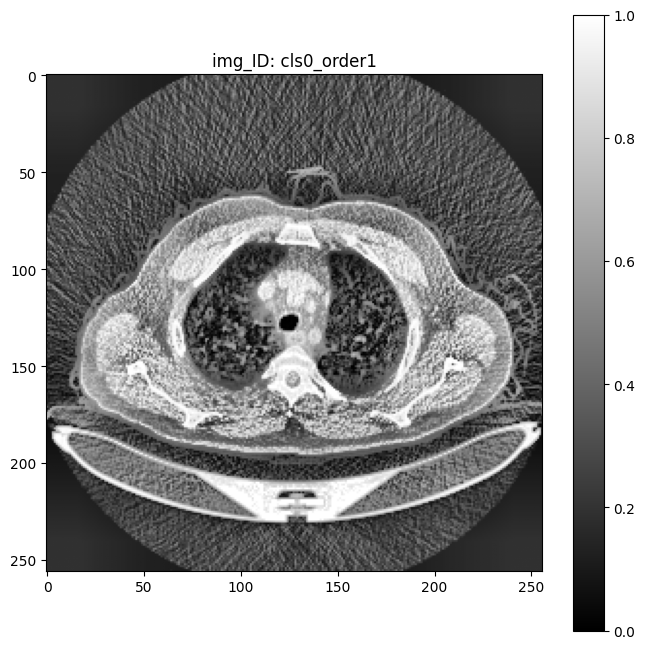

In [11]:
# load a image 
img_ID = "cls0_order1"

c1 = pipe_meta["img_ID"] == img_ID
arr_img_path = Path(PureWindowsPath(pipe_meta[c1][f"path_img_pipe"].item()))
arr_img = np.load(arr_img_path)

plt.figure(figsize=(8,8))
plt.imshow(arr_img, cmap='gray', 
           # vmin=0, vmax=255
           # vmin=0, vmax=1
          )
plt.colorbar()
plt.title(f"img_ID: {img_ID}")
plt.show()

In [12]:
arr_img_path

PosixPath('../../../data/pipe004/pipe004_imgs/Normal cases/pipe004_cls0_order1_.npy')

## Custom Pytorch Dataset

In [13]:
# Creating dataset class
from typing import Tuple, Dict, List


class customPytorchDatset(Dataset):
    
    def __init__(self, d_meta):
        self.d_meta = d_meta

    def __len__(self) -> int: 
        "Returns the total number of samples."
        return len(self.d_meta)

    def __getitem__(self, index):
        fpath = Path(PureWindowsPath(self.d_meta["path_img_pipe"][index]))
        arr_img = np.load(fpath)
        arr_img = np.expand_dims(arr_img, axis=0) #
        arr_img = torch.tensor(arr_img)

        y_true = self.d_meta["cls_id"][index]
        y_true = torch.tensor(y_true, dtype=torch.int64)
        
        img_id = self.d_meta["img_ID"][index]

        
        return arr_img, y_true, img_id
    

In [14]:
arr_img, y_true, img_id = next(iter(customPytorchDatset(d_meta = pipe_meta)))
arr_img, y_true, img_id 

(tensor([[[0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1922, 0.1922],
          [0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1922, 0.1922],
          [0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1922, 0.1922],
          ...,
          [0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1922, 0.1922],
          [0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1922, 0.1922],
          [0.1922, 0.1922, 0.1922,  ..., 0.1922, 0.1922, 0.1922]]],
        dtype=torch.float64),
 tensor(0),
 'cls0_order1')

In [15]:
arr_img.shape

torch.Size([1, 256, 256])

In [16]:
        # y = y_true.to(torch.int64)
        # arr_img = torch.tensor(arr_img, dtype=torch.uint8)

In [17]:
# torch.tensor(arr_img, dtype=torch.uint8)

In [18]:
# torch.tensor(y_true, dtype=torch.int64)

In [19]:
# arr_img, y_true, img_id = next(iter(trn_loader))

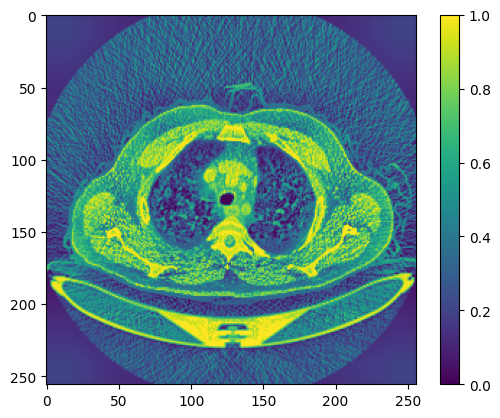

In [20]:
plt.imshow(arr_img.numpy()[0].squeeze())
plt.colorbar()
plt.show()

## Arch01

In [21]:
class vanilla2DCNN_v1(nn.Module):
    def __init__(self,
                 in_channels,
                 num_classes,
                ):
        super(vanilla2DCNN_v1, self).__init__()
        
        # Input layer
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=16, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)  #  out shape (16, 256, 256)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # out shape (16, 128, 128)
        
        self.conv2 = nn.Conv2d(in_channels=16, 
                               out_channels=32, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1)  # out shape (32, 128, 128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # out shape (32, 64, 64)
        
        # Flatten to feed into FC layer: 32 * 64 * 64
        self.fc1 = nn.Linear(in_features=32 * 64 * 64, 
                             out_features=num_classes)  
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten
        logits = self.fc1(x)
        return logits  # raw scores (logits)

## Training

### Training configuration

In [22]:
cfg.preprocessing_pipe

'pipe004'

In [23]:
Training_trackID = f"TrainTrack_022" #"TrainTrack_" + "ID"  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< CAREFUL with OVERWRITE

pipe_params = {'prepro_pipe': {'pipe_name':cfg.preprocessing_pipe, # each a transformation step is modified, id changes.
                               'source_code': 'FR_t01e01nb02v4',
                              }, 
               'architecture':{'arch_ID':'vanilla2DCNN_v1', # each arch is modified, id changes.
                               'params': {'in_channels':1,
                                          'num_classes':3,
                                         },
                               'source_code': cfg.THIS_NOTEBOOK_REF
                              },
               'split_strategy': {'split_strategy_id':'splt_strategy_002', # each one parameter change, id changes.
                                  'cv': 'custom_StratifiedKFold()',
                                  'n_split':5,
                                  'cls_col':"cls_id",
                                  'inst_n_order_col':"img_n_order",
                                  'shuffle_instances':False,
                                  'seed':0,
                                  'comment': 'shuffle_instances=True generates leakage',
                                 },
               'training_step': {'TrackID': Training_trackID,
                                 'training_strategy_id':'trn_strategy_001', # each one parameter change, id changes.
                                 'source_code':cfg.THIS_NOTEBOOK_REF,
                                 'batch_size':50,
                                 'epochs':10,
                                 'lr':0.001,
                                 'loss_fn':'CrossEntropyLoss',
                                 'balance_strategy': "class weight in loss_fn",
                                 'optimizer': 'Adam',
                                 'verbose_epo_steps':1,
                                 'save_model':False,
                                },
               "general_comments": "", 
              }
#==============================================================================
to_save_root = cfg.ROOT_TO_SAVE_RESLT
track_train_id = pipe_params['training_step']['TrackID']

#----------------------------------------------------------
# creating folder to store ML pipeline params
root_perfom_across_epo = os.path.join(to_save_root,
                                      track_train_id,
                                      'ML_pipe_params',)
os.makedirs(root_perfom_across_epo, exist_ok=True)

#----------------------------------------------------------
# Saving ML pipeline params
pickle_fname = f"ML_pipe_all_params_{Training_trackID}.pkl"
fpath = os.path.join(root_perfom_across_epo, pickle_fname)
with open(fpath, 'wb') as fp:
    pickle.dump(pipe_params, fp)


### Stratify KFold 

In [24]:
validation_imgID_folds = custom_StratifiedKFold(d_meta=pipe_meta,
                                                n_splits=pipe_params['split_strategy']['n_split'],
                                                cls_col=pipe_params['split_strategy']['cls_col'],
                                                inst_n_order_col=pipe_params['split_strategy']['inst_n_order_col'],
                                                shuffle_instances=pipe_params['split_strategy']['shuffle_instances'],
                                                random_state=pipe_params['split_strategy']['seed'],
                                               )
#====================================
print(f"Check number of images per fold:")
for f in validation_imgID_folds:
    print(f"  Count of unique IDs per folds : {np.unique(f).shape} | {f.shape} ")
print(f" Total of img_ids: {np.hstack(validation_imgID_folds).shape}")

Check number of images per fold:
  Count of unique IDs per folds : (221,) | (221,) 
  Count of unique IDs per folds : (219,) | (219,) 
  Count of unique IDs per folds : (219,) | (219,) 
  Count of unique IDs per folds : (219,) | (219,) 
  Count of unique IDs per folds : (219,) | (219,) 
 Total of img_ids: (1097,)


### Training steps 

In [25]:
%%time
in_channels    = pipe_params['architecture']['params']['in_channels']
num_classes    = pipe_params['architecture']['params']['num_classes']
arch_id        = pipe_params['architecture']['arch_ID']

epochs         = pipe_params['training_step']['epochs']
batch_size     = pipe_params['training_step']['batch_size']
lr             = pipe_params['training_step']['lr']
track_train_id = pipe_params['training_step']['TrackID']
save_model     = pipe_params['training_step']['save_model']





for fold_n, imgIDs_fold in enumerate(validation_imgID_folds):

    foldID = f"seed{pipe_params['split_strategy']['seed']}_fold{fold_n}"
    
    #_________________________________________________________________
    # Split train and test dataset.
    c_tst = pipe_meta["img_ID"].isin(imgIDs_fold)
    d_tst = pipe_meta[c_tst].reset_index(drop=True)
    
    d_trn = pipe_meta[~c_tst].reset_index(drop=True)
    
    #_________________________________________________________________
    # Extracting weights for each class 
    class_counts = d_trn["cls_id"].value_counts().sort_index()
    N = class_counts.sum()
    K = len(class_counts)
    weights_ = N / (K * class_counts)
    weights = weights_.to_dict()
    
    #_________________________________________________________________
    # Custom pytorch dataset    
    trn_dataset = customPytorchDatset(d_meta = d_trn)
    tst_dataset = customPytorchDatset(d_meta = d_tst)
    
    #..................................................
    # Custom pytorch dataloader
    trn_loader = DataLoader(dataset=trn_dataset,
                            batch_size=batch_size,
                            shuffle=True,)

    tst_loader = DataLoader(dataset=tst_dataset,
                            batch_size=batch_size,
                            shuffle=False,)
    
    #_________________________________________________________________
    model = []
    model = vanilla2DCNN_v1(in_channels,
                           num_classes,).to(device)
    
    #_________________________________________________________________
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    #_________________________________________________________________
    print(f"\n__________________\nTraining foldID: {foldID}")
    trn_rslts, tst_rslts = train(model=model,
                                 trn_loader=trn_loader,
                                 tst_loader=tst_loader,
                                 optimizer=optimizer,
                                 weights=weights,
                                 epochs=epochs,
                                 arch_id=arch_id,
                                 foldID=foldID,
                                 track_train_id=track_train_id,
                                 to_save_root=cfg.ROOT_TO_SAVE_RESLT,
                                 verbose_epo_steps=1,
                                 save_model=save_model
                                )
    #_________________________________________________________________
    # Free memory
    model.cpu()
    del model, 
    del trn_dataset, tst_dataset
    del trn_loader, tst_loader
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

    #_________________________________________________________________
    # break

    


__________________
Training foldID: seed0_fold0
Epo: 0 | tr_loss: 2.4580 | tr_acc: 0.3699 | tst_loss: 0.9977 | tst_acc: 0.5475 |tst_ba: 0.1083 |tst_f1: 0.3972 |tst_pr: 0.6940 |tst_rc: 0.4056 |lr: 0.001000 |
Epo: 1 | tr_loss: 0.6889 | tr_acc: 0.8105 | tst_loss: 0.6676 | tst_acc: 0.6652 |tst_ba: 0.2913 |tst_f1: 0.5298 |tst_pr: 0.6101 |tst_rc: 0.5275 |lr: 0.001000 |
Epo: 2 | tr_loss: 0.2647 | tr_acc: 0.9452 | tst_loss: 0.7017 | tst_acc: 0.6652 |tst_ba: 0.4001 |tst_f1: 0.5856 |tst_pr: 0.6014 |tst_rc: 0.6000 |lr: 0.001000 |
Epo: 3 | tr_loss: 0.0828 | tr_acc: 0.9886 | tst_loss: 0.7561 | tst_acc: 0.6516 |tst_ba: 0.3803 |tst_f1: 0.5653 |tst_pr: 0.5664 |tst_rc: 0.5869 |lr: 0.001000 |
Epo: 4 | tr_loss: 0.0382 | tr_acc: 0.9943 | tst_loss: 0.9965 | tst_acc: 0.5973 |tst_ba: 0.4073 |tst_f1: 0.5348 |tst_pr: 0.5599 |tst_rc: 0.6049 |lr: 0.001000 |
Epo: 5 | tr_loss: 0.0236 | tr_acc: 0.9966 | tst_loss: 0.8901 | tst_acc: 0.6652 |tst_ba: 0.3970 |tst_f1: 0.5861 |tst_pr: 0.5933 |tst_rc: 0.5980 |lr: 0.001000